# Пайплайн Моделирования

Этот ноутбук предоставляет пошаговый контроль над процессом обучения и тюнинга моделей. Логика разбита на отдельные ячейки для удобства отладки и инспекции переменных (`X_train`, `folds`, `results` и т.д.).

**Структура:**
1. Импорт и настройка
2. Загрузка данных
3. Настройка валидации
4. Стандартное обучение (Standard Training)
5. Тюнинг гиперпараметров (Hyperparameter Tuning)
6. Анализ результатов

## 1. Импорты и настройка окружения

Импортируем библиотеки, настраиваем пути к `src` и загружаем конфигурацию (`models.yml`).

In [1]:
import sys
import yaml
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Настройка путей
PROJECT_ROOT = Path("../..").resolve()
if str(PROJECT_ROOT / "03_src") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "03_src"))

# Внутренние функции для гранулярного контроля
from models.modeling_pipeline import (
    _load_yaml, _ensure_sorted_index, _validate_features, SplitConfig,
    _temporal_train_valid_test_split, _time_series_folds, _compute_class_weights,
    _fit_and_eval_model, _evaluate, _confusion_and_report, _predict_xgboost, _predict_catboost
)
from models.hyperparameter_tuning import tune_hyperparameters

# Загрузка конфигов
MODELS_CONFIG_PATH = PROJECT_ROOT / "04_configs/models.yml"
SPLITS_CONFIG_PATH = PROJECT_ROOT / "04_configs/splits.yml"

with open(MODELS_CONFIG_PATH, "r", encoding="utf-8") as f:
    models_config = yaml.safe_load(f)

pipeline_settings = models_config.get("pipeline_settings", {})
RUN_TUNING = pipeline_settings.get("run_hyperparameter_tuning", False)
TARGET_COL = models_config.get("data", {}).get("target_column", "y_buy_else_atr")

print(f"Project Root: {PROJECT_ROOT}")
print(f"Mode: {'HYPERPARAMETER TUNING' if RUN_TUNING else 'STANDARD TRAINING'}")
print(f"Target Column: {TARGET_COL}")

Project Root: /mnt/c/Users/Shchurov/Хранилище/Документы/05_Программирование/02_projects/personal/trading_predictor
Mode: STANDARD TRAINING
Target Column: y_buy_else_atr


## 2. Загрузка и подготовка данных

Считываем parquet-файл, указанный в конфиге, сортируем по времени и выделяем матрицу признаков `X` и целевую переменную `y`.

In [2]:
features_path = models_config.get("data", {}).get("features_path", "01_data/processed/eurusd_features.parquet")
features_fp = PROJECT_ROOT / features_path

if not features_fp.exists():
    raise FileNotFoundError(f"File not found: {features_fp}")

df = pd.read_parquet(features_fp)
df = _ensure_sorted_index(df)
X, y = _validate_features(df, target_col=TARGET_COL)

print(f"Dataset Shape: {X.shape}")
display(X.head())

Dataset Shape: (88497, 13)


,f_macd_12_26_9_hist,f_di_diff_14,f_adx_14,f_rsi_14,f_roc_5,f_atr_14_pct,f_range_over_atr,f_donchian_pos_20,f_bandwidth_20,f_ret_24,f_rolling_std_ret_5,f_zscore_close_50,f_vwap_dev_over_atr14
Time,,,,,,,,,,,,,
2010-01-05 18:00:00+00:00,-0.000999,-11.089331,27.555309,37.683445,-0.442239,0.002074,1.557636,0.116704,0.006777,-0.003489,0.001077,-0.319420,-1.197870
2010-01-05 19:00:00+00:00,-0.001046,-10.544741,27.291437,39.801617,-0.246447,0.002024,0.687532,0.163385,0.007542,-0.002974,0.001145,-0.228425,-0.822610
2010-01-05 20:00:00+00:00,-0.001039,-9.332584,26.849712,39.351471,-0.344043,0.001922,0.304219,0.148797,0.008220,-0.003086,0.000922,-0.286079,-0.535744
2010-01-05 21:00:00+00:00,-0.001000,-9.385408,26.478329,38.831223,-0.251368,0.001833,0.368369,0.132751,0.008831,-0.003315,0.000916,-0.351027,-0.279939
2010-01-05 22:00:00+00:00,-0.000942,-10.392597,26.291071,38.140102,-0.201512,0.001743,0.327513,0.112328,0.009407,-0.003475,0.000918,-0.430012,-0.118719


## 3. Настройка валидации (Cross-Validation)

Инициализируем стратегию разбиения `TimeSeriesSplit` на основе `splits.yml`.  
Переменные:
- `X_train`, `X_valid`, `X_test`: Глобальные выборки
- `folds`: Индексы для кросс-валидации (Walk-Forward)

In [3]:
splits_cfg_raw = _load_yaml(SPLITS_CONFIG_PATH)
split_config = SplitConfig(
    method=splits_cfg_raw.get("splits", {}).get("method", "ratios"),
    ratios=splits_cfg_raw.get("splits", {}).get("ratios", {"train": 0.7, "valid": 0.15, "test": 0.15}),
    dates=splits_cfg_raw.get("splits", {}).get("dates", {}),
    n_splits=int(splits_cfg_raw.get("time_series_cv", {}).get("n_splits", 5)),
    max_train_size=splits_cfg_raw.get("time_series_cv", {}).get("max_train_size"),
    test_size=splits_cfg_raw.get("time_series_cv", {}).get("test_size"),
    gap=int(splits_cfg_raw.get("time_series_cv", {}).get("gap", 0)),
    artifacts=splits_cfg_raw.get("artifacts", {}),
)

# 1. Глобальное разбиение (Train/Valid/Test)
(X_train, y_train), (X_valid, y_valid), (X_test, y_test), split_meta = _temporal_train_valid_test_split(X, y, split_config)

# 2. Фолды для CV (на Train + Valid)
X_trval = pd.concat([X_train, X_valid])
y_trval = pd.concat([y_train, y_valid])
folds = _time_series_folds(X_trval, y_trval, split_config)

print("Split Metadata:", split_meta)
print(f"\nNumber of CV Folds: {len(folds)}")
for i, (train_idx, valid_idx) in enumerate(folds):
    print(f"Fold {i+1}: Train size {len(train_idx)} | Valid size {len(valid_idx)}")

Split Metadata: {'method': 'ratios', 'ratios': {'train': 0.7, 'valid': 0.15, 'test': 0.15}, 'train_end': '2019-09-24 22:00:00+00:00', 'valid_end': '2021-11-12 04:00:00+00:00', 'test_start': '2021-11-12 05:00:00+00:00'}

Number of CV Folds: 5
Fold 1: Train size 12536 | Valid size 12536
Fold 2: Train size 25072 | Valid size 12536
Fold 3: Train size 37608 | Valid size 12536
Fold 4: Train size 50144 | Valid size 12536
Fold 5: Train size 62680 | Valid size 12536


## 4. Стандартный цикл обучения (Standard Training Loop)

Эта ячейка выполняется, **только если** `run_hyperparameter_tuning: false`.
- Проходит по всем enabled моделям.
- Использует параметры (`use_best_params` -> `default` или `best`).
- Обучает на фолдах, усредняет метрики.
- Финально обучает на Train+Valid и тестирует на Test.

In [4]:
results = {}

if not RUN_TUNING:
    print("🚀 Starting Standard Training...\n")
    
    # Import additional functions if needed
    from models.modeling_pipeline import _find_best_threshold

    # Calculate Class Weights
    if pipeline_settings.get("use_class_weights", False):
        class_weights = _compute_class_weights(y_train)
        print(f"  -> Class Weights: 0={class_weights.get(0, 1.0):.2f}, 1={class_weights.get(1, 1.0):.2f}")
    else:
        class_weights = {0: 1.0, 1: 1.0}
        print("  -> Class Weights: Disabled (using 1.0 for all classes)")

    # Model Loop
    enabled_models = [
        name for name, cfg in (models_config.get("models") or {}).items() 
        if (cfg or {}).get("enabled", False)
    ]
    common_cfg = models_config.get("common", {})
    
    for model_name in enabled_models:
        print(f"\n{'='*50}")
        print(f"Processing Model: {model_name}")
        print(f"{'='*50}")
        
        # Get model parameters
        m_config = (models_config.get("models", {}).get(model_name) or {})
        use_best = m_config.get("use_best_params", False)
        base_params = m_config.get("default_params", {})
        best_p = m_config.get("best_params", {})
        
        final_params = {**base_params, **best_p} if use_best else base_params
        model_run_cfg = {"params": final_params, "fit": m_config.get("fit", {})}
        
        print(f"  -> Using {'best' if use_best else 'default'} params")
        
        # --- Cross-Validation Loop ---
        fold_metrics = []
        fold_thresholds = []
        
        for fold_id, (tr_idx, va_idx) in enumerate(folds, start=1):
            X_tr_f, y_tr_f = X_trval.iloc[tr_idx], y_trval.iloc[tr_idx]
            X_va_f, y_va_f = X_trval.iloc[va_idx], y_trval.iloc[va_idx]
            
            # Fit model
            clf, _ = _fit_and_eval_model(
                model_name, X_tr_f, y_tr_f, X_va_f, y_va_f, class_weights, model_run_cfg, common_cfg
            )
            
            # Get probabilities for threshold optimization
            if model_name == "catboost":
                _, proba_valid = _predict_catboost(clf, X_va_f)
            elif model_name == "xgboost":
                _, proba_valid = _predict_xgboost(clf, X_va_f)
            else:  # lightgbm or other sklearn-compatible
                proba_valid = clf.predict_proba(X_va_f)
            
            # FIX: Convert 2D proba array to 1D (class 1 probability) for ALL models
            if isinstance(proba_valid, np.ndarray) and proba_valid.ndim == 2:
                proba_valid = proba_valid[:, 1]
            
            # Find optimal threshold using validation set
            best_thr, best_f1 = _find_best_threshold(y_va_f.values, proba_valid)
            fold_thresholds.append(best_thr)
            
            # Re-evaluate with best threshold
            pred_valid = (proba_valid >= best_thr).astype(int)
            metrics_best = _evaluate(y_va_f.values, pred_valid, proba_valid)
            metrics_best["selected_threshold"] = best_thr
            
            fold_metrics.append(metrics_best)
            print(f"  -> Fold {fold_id}: Thr={best_thr:.2f} | F1={metrics_best.get('f1_class_1', 0):.4f} | PnL={metrics_best.get('simple_pnl', 0):+.1f}")
        
        # Calculate average metrics across folds
        avg_metrics = {
            k: float(np.nanmean([m.get(k, np.nan) for m in fold_metrics])) 
            for k in fold_metrics[0].keys()
        }
        avg_threshold = float(np.mean(fold_thresholds))
        avg_metrics["avg_threshold"] = avg_threshold
        
        print(f"  -> CV Avg: Thr={avg_threshold:.2f} | F1={avg_metrics.get('f1_class_1', 0):.4f} | PnL={avg_metrics.get('simple_pnl', 0):+.1f}")

        # --- Final Fit on Train+Valid & Test Evaluation ---
        print(f"\n  -> Training final model on full Train+Valid set...")
        clf_final, _ = _fit_and_eval_model(
            model_name, X_trval, y_trval, X_valid, y_valid, class_weights, model_run_cfg, common_cfg
        )
        
        # Get test predictions
        if model_name == "catboost":
            _, y_proba_test = _predict_catboost(clf_final, X_test)
        elif model_name == "xgboost":
            _, y_proba_test = _predict_xgboost(clf_final, X_test)
        else:
            y_proba_test = clf_final.predict_proba(X_test)
        
        # FIX: Convert 2D proba array to 1D (class 1 probability)
        if isinstance(y_proba_test, np.ndarray) and y_proba_test.ndim == 2:
            y_proba_test_1 = y_proba_test[:, 1]
        else:
            y_proba_test_1 = y_proba_test
        
        # Apply average threshold from CV to test predictions
        final_thr = avg_threshold  # Use avg from CV, not from avg_metrics dict
        y_pred_test = (y_proba_test_1 >= final_thr).astype(int)
        
        # Evaluate on test set
        test_metrics = _evaluate(y_test.values, y_pred_test, y_proba_test_1)
        test_metrics["selected_threshold"] = final_thr
        test_details = _confusion_and_report(y_test.values, y_pred_test)
        
        print(f"  -> Test: Thr={final_thr:.2f} | F1={test_metrics.get('f1_class_1', 0):.4f} | PnL={test_metrics.get('simple_pnl', 0):+.1f}")

        results[model_name] = {
            "cv_avg": avg_metrics,
            "cv_folds": fold_metrics,
            "test_metrics": test_metrics,
            "test_details": test_details,
            "model_obj": clf_final
        }

    print("\n" + "="*50)
    print("✅ Standard Training Complete.")
    print(f"   Models trained: {list(results.keys())}")
else:
    print("⚠️ Standard Training skipped (Mode = Hyperparameter Tuning)")


🚀 Starting Standard Training...

  -> Class Weights: 0=0.74, 1=1.54

Processing Model: xgboost
  -> Using default params
  -> Fold 1: Thr=0.25 | F1=0.4911 | PnL=-4376.0
  -> Fold 2: Thr=0.25 | F1=0.4782 | PnL=-4658.0
  -> Fold 3: Thr=0.25 | F1=0.5015 | PnL=-4146.0
  -> Fold 4: Thr=0.49 | F1=0.4960 | PnL=-4195.0
  -> Fold 5: Thr=0.25 | F1=0.5039 | PnL=-4092.0
  -> CV Avg: Thr=0.30 | F1=0.4941 | PnL=-4293.4

  -> Training final model on full Train+Valid set...
  -> Test: Thr=0.30 | F1=0.4834 | PnL=-3607.0

Processing Model: lightgbm
  -> Using default params
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.691504
  -> Fold 1: Thr=0.39 | F1=0.4913 | PnL=-4368.0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.691247
  -> Fold 2: Thr=0.42 | F1=0.4787 | PnL=-4626.0
Training until validation scores don't improve for 50 rounds
Early stop

## 5. Тюнинг гиперпараметров (Hyperparameter Tuning Loop)

Эта ячейка выполняется, **только если** `run_hyperparameter_tuning: true`.
- Запускает Optuna/GridSearch.
- Находит лучшие параметры.
- Обновляет `models.yml`.

In [5]:
if RUN_TUNING:
    print("🚀 Starting Hyperparameter Tuning (Optuna)...")
    tuning_results = tune_hyperparameters(
        # Используем models.yml как конфиг, т.к. секция hp_tuning_params там
        config_path="04_configs/models.yml",
        splits_config_path=str(SPLITS_CONFIG_PATH.relative_to(PROJECT_ROOT)),
        models_config_path=str(MODELS_CONFIG_PATH.relative_to(PROJECT_ROOT)),
        update_models_yaml=True
    )
    print("✅ Tuning Complete. Best parameters saved to models.yml.")
else:
    print("⚠️ Tuning skipped (Mode = Standard Training)")

⚠️ Tuning skipped (Mode = Standard Training)


## 6. Вывод метрик (Metrics Display)

Сравнительная таблица метрик всех обученных моделей.

In [6]:
metrics_df = pd.DataFrame()

if not RUN_TUNING and results:
    data = []
    for m, res in results.items():
        row = {"Model": m}
        row.update(res["test_metrics"])
        data.append(row)
    
    metrics_df = pd.DataFrame(data)
    print("Test Set Metrics:")
    display(metrics_df)
    
elif RUN_TUNING and 'tuning_results' in locals():
    print("Tuning Results Summary (Check artifacts directory for details).")

Test Set Metrics:


,Model,precision_class_1,recall_class_1,f1_class_1,f1,f1_class_0,f1_macro,balanced_accuracy,accuracy,simple_pnl,logloss,roc_auc,selected_threshold
0,xgboost,0.338266,0.846689,0.483404,0.483404,0.263475,0.373440,0.505081,0.392739,-3607.0,0.701835,0.520317,0.298
1,lightgbm,0.346218,0.558923,0.427578,0.427578,0.552700,0.490139,0.512938,0.497816,-2212.0,0.733716,0.520542,0.312
2,catboost,0.339617,0.837037,0.483188,0.483188,0.282450,0.382819,0.507511,0.399141,-3522.0,0.701109,0.525357,0.330


## 7. Финансовый отчет (Financial Report)

Сводная таблица по Simple PnL и порогам на Test Set.

In [7]:
if not RUN_TUNING and results:
    fin_data = []
    for m, res in results.items():
        metrics = res["test_metrics"]
        fin_data.append({
            "Model": m,
            "Selected Threshold": metrics.get("selected_threshold"),
            "Simple PnL (R=1)": metrics.get("simple_pnl"),
            "F1 Class 1": metrics.get("f1_class_1"),
            "Precision": metrics.get("precision_class_1"),
            "Recall": metrics.get("recall_class_1")
        })
    
    fin_df = pd.DataFrame(fin_data)
    print("Financial Report (Test Set):")
    display(fin_df)


Financial Report (Test Set):


,Model,Selected Threshold,Simple PnL (R=1),F1 Class 1,Precision,Recall
0,xgboost,0.298,-3607.0,0.483404,0.338266,0.846689
1,lightgbm,0.312,-2212.0,0.427578,0.346218,0.558923
2,catboost,0.330,-3522.0,0.483188,0.339617,0.837037


## 8. Визуализация (Visualization)

Сравнение моделей по ключевым метрикам (F1, Precision, Recall).

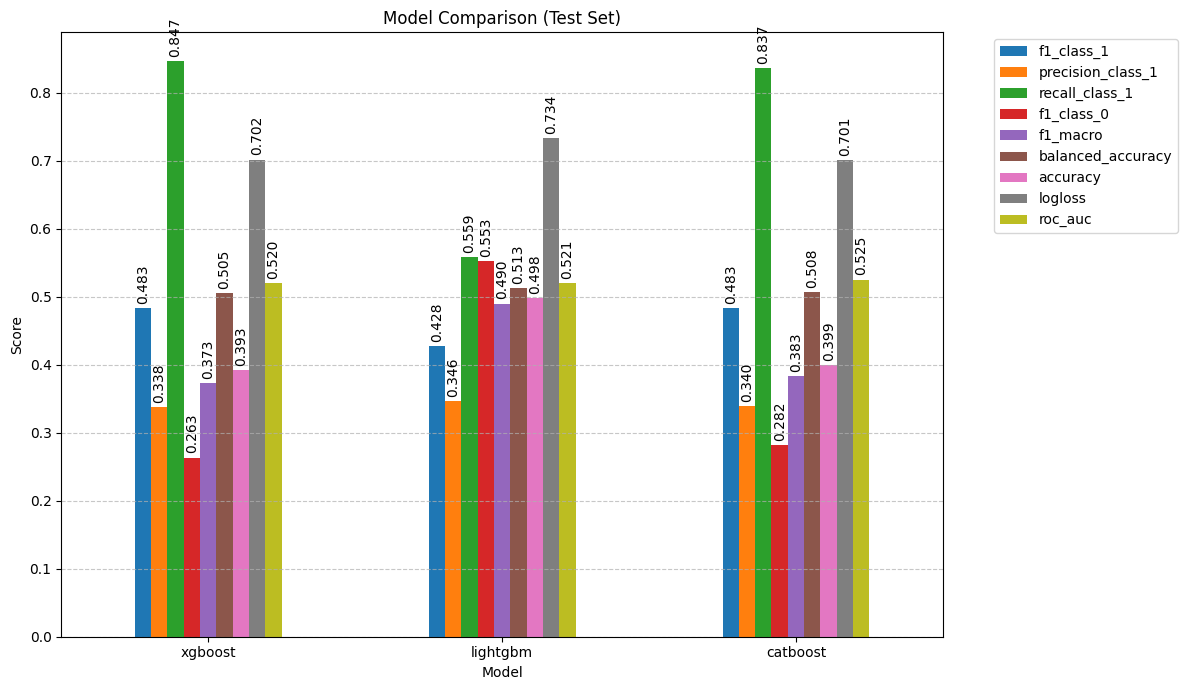

In [8]:
if not RUN_TUNING and not metrics_df.empty:
    target_cols = [
        "f1_class_1", "precision_class_1", "recall_class_1", "f1_class_0", 
        "f1_macro", "balanced_accuracy", "accuracy", "logloss", "roc_auc"
    ]
    valid_cols = [c for c in target_cols if c in metrics_df.columns]
    
    if valid_cols:
        ax = metrics_df.set_index("Model")[valid_cols].plot(kind="bar", figsize=(12, 7))
        plt.title("Model Comparison (Test Set)")
        plt.ylabel("Score")
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add value labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3, rotation=90)
            
        plt.tight_layout()
        plt.show()

## 9. Анализ ошибок (Confusion Matrix)

Визуализация матриц ошибок для более детального понимания качества классификации.

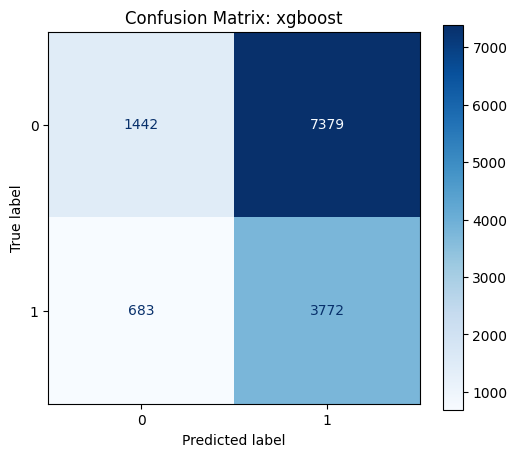

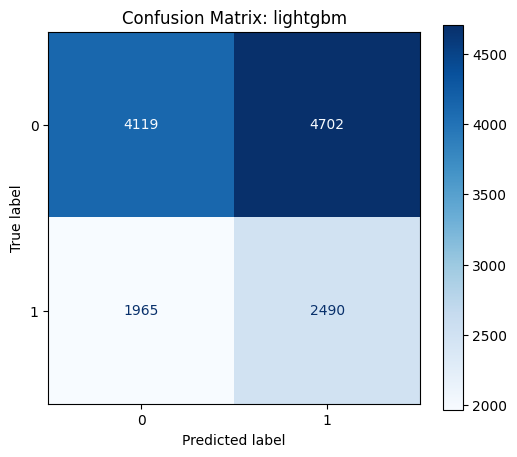

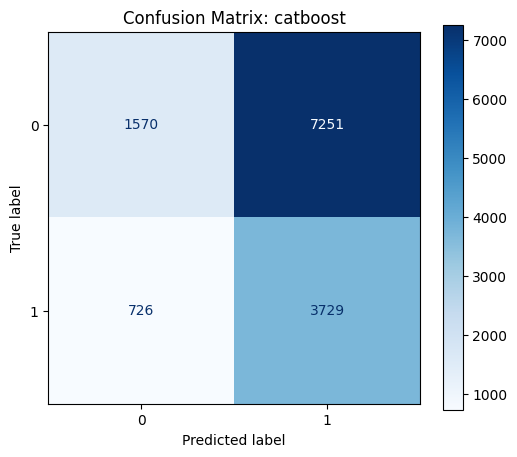

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

if not RUN_TUNING and results:
    for m, res in results.items():
        cm = res["test_details"]["confusion_matrix"]
        disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm), display_labels=[0, 1])
        fig, ax = plt.subplots(figsize=(6, 5))
        disp.plot(ax=ax, cmap="Blues", values_format="d")
        ax.set_title(f"Confusion Matrix: {m}")
        plt.show()

## 10. Сохранение артефактов

Сохраняем отчет (JSON/CSV), модели и графики в директорию `06_reports`.

In [10]:
from datetime import datetime
import json
import joblib
import shutil
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

if not RUN_TUNING and results:
    # 1. Setup Directory Structure
    exp_id = models_config.get("experiment", {}).get("current_id", "exp_manual")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = PROJECT_ROOT / "06_reports" / f"{exp_id}_{timestamp}"
    
    dirs = {
        "root": save_dir,
        "models": save_dir / "models",
        "plots": save_dir / "plots",
        "metrics": save_dir / "metrics"
    }
    for d in dirs.values():
        d.mkdir(parents=True, exist_ok=True)
    
    print(f"📂 Saving experiment results to: {save_dir}")

    # 2. Save Config Snapshot
    with open(dirs["metrics"] / "experiment_config.yaml", "w", encoding="utf-8") as f:
        yaml.safe_dump(models_config, f, allow_unicode=True, sort_keys=False)

    # 3. Save Metrics & Logs
    if not metrics_df.empty:
        metrics_path = dirs["metrics"] / "metrics_report.csv"
        metrics_df.to_csv(metrics_path, index=False)
        print(f"  -> Metrics saved: {metrics_path.name}")
        
    results_serializable = {}
    
    # 4. Save Models & Plots per Model
    for model_name, res in results.items():
        # Save Model
        model_subdir = dirs["models"] / model_name
        model_subdir.mkdir(exist_ok=True)
        
        clf = res.get("model_obj")
        if clf:
            joblib.dump(clf, model_subdir / "model.joblib")
            if model_name == "catboost":
                try:
                    clf.save_model(str(model_subdir / "model.cbm"))
                except Exception:
                    pass
        
        # Save Plots (Regenerate to save file)
        # Confusion Matrix
        cm = res["test_details"]["confusion_matrix"]
        fig, ax = plt.subplots(figsize=(6, 5))
        ConfusionMatrixDisplay(confusion_matrix=np.array(cm), display_labels=[0, 1]).plot(ax=ax, cmap="Blues")
        ax.set_title(f"Confusion Matrix: {model_name}")
        fig.savefig(dirs["plots"] / f"cm_{model_name}.png", dpi=150)
        plt.close(fig)
        
        # Prepare for JSON
        results_serializable[model_name] = {k: v for k, v in res.items() if k != "model_obj"}

    # 5. Save Model Comparison Plot
    if not metrics_df.empty:
        target_cols = [
            "f1_class_1", "precision_class_1", "recall_class_1", "f1_class_0", 
            "f1_macro", "balanced_accuracy", "accuracy", "logloss", "roc_auc"
        ]
        valid_cols = [c for c in target_cols if c in metrics_df.columns]
        
        if valid_cols:
            fig, ax = plt.subplots(figsize=(12, 7))
            metrics_df.set_index("Model")[valid_cols].plot(kind="bar", ax=ax)
            ax.set_title(f"Model Comparison ({exp_id})")
            ax.set_ylabel("Score")
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Add value labels
            for container in ax.containers:
                ax.bar_label(container, fmt='%.3f', padding=3, rotation=90)
                
            plt.tight_layout()
            fig.savefig(dirs["plots"] / "models_comparison.png", dpi=150)
            plt.close(fig)

    # Save Full JSON Report
    with open(dirs["metrics"] / "metrics_report.json", "w", encoding="utf-8") as f:
        json.dump(results_serializable, f, default=str, indent=2, ensure_ascii=False)
        
    print("✅ All artifacts saved successfully.")

📂 Saving experiment results to: /mnt/c/Users/Shchurov/Хранилище/Документы/05_Программирование/02_projects/personal/trading_predictor/06_reports/exp_0020_20251212_005056
  -> Metrics saved: metrics_report.csv
✅ All artifacts saved successfully.
